In [1]:
%matplotlib inline
import glob, os, sys, timeit
import matplotlib
import numpy as np

sys.path.append('../')
from pyqsofit.PyQSOFit import QSOFit
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

QSOFit.set_mpl_style()

In [2]:
# Show the versions so we know what works
import astropy
import lmfit
import pyqsofit

print(astropy.__version__)
print(lmfit.__version__)
print(pyqsofit.__version__)

import emcee  # optional, for MCMC

print(emcee.__version__)

5.3.4
1.2.2
2.0.0
3.1.4


In [3]:
print(pyqsofit.__path__)


['/home/osama/Downloads/ARIES/PyQSOFit/pyqsofit']


In [4]:
path_ex = '.' #os.path.join(pyqsofit.__path__[0], '..', 'example')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Hengxiao Guo'
primary_hdu = fits.PrimaryHDU(header=hdr0)

In [5]:
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

line_priors = np.rec.array([
    (6564.61, 'Ha', 6400, 6800, 'Ha_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 6400, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 1, 0.001, 1),
    (6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 1, 0.003, 1),
    (6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),
    (6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),

    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Hb', 4640, 5100, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.005, 1, 1, 0, 0.001, 1),

    #(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 99, 0, 0, -0.001, 1),

    #(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 1, 1, 0, 0.001, 1),

    #(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 0, 0, 0, 0.001, 1),
    #(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

    (2798.75, 'MgII', 2700, 2900, 'MgII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (2798.75, 'MgII', 2700, 2900, 'MgII_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),

    (1908.73, 'CIII', 1700, 1970, 'CIII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
    #(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.0, 0.0, 1e10, 1e-3, 5e-4,  0.00169, 0.01,  1, 1, 0, 0.002, 1),
    #(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
    #(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

    (1549.06, 'CIV', 1500, 1700, 'CIV_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    # (1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

    #(1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
    #(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

    (1215.67, 'Lya', 1150, 1290, 'Lya_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05, 0.02, 0, 0, 0, 0.05, 1),
    (1240.14, 'Lya', 1150, 1290, 'NV1240', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.01, 0.005, 0, 0, 0, 0.002, 1),
    # (1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 0, 0, 0.002, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

In [6]:
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  1), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 1), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     1.0,   0.0,   1e10,  1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   1), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  1), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 1), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.5,   0.1,   2.0,   1), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  1), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

In [7]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[1350, 1450, 3000, 4200, 5100]],
        [[
            # [2240, 2650], 
            [4435, 4685],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

In [8]:
Table(line_priors)

<Table length=18>
 lambda compname  minwav  maxwav  linename ... windex findex  fvalue  vary
float32 bytes20  float32 float32  bytes20  ... int32  int32  float32 int32
------- -------- ------- ------- --------- ... ------ ------ ------- -----
6564.61       Ha  6400.0  6800.0     Ha_br ...      0      0    0.05     1
6564.61       Ha  6400.0  6800.0     Ha_na ...      1      0   0.002     1
6549.85       Ha  6400.0  6800.0   NII6549 ...      1      1   0.001     1
6585.28       Ha  6400.0  6800.0   NII6585 ...      1      1   0.003     1
6718.29       Ha  6400.0  6800.0   SII6718 ...      1      2   0.001     1
6732.67       Ha  6400.0  6800.0   SII6732 ...      1      2   0.001     1
4862.68       Hb  4640.0  5100.0     Hb_br ...      0      0    0.01     1
4862.68       Hb  4640.0  5100.0     Hb_na ...      1      0   0.002     1
 4960.3       Hb  4640.0  5100.0 OIII4959c ...      1      0   0.002     1
5008.24       Hb  4640.0  5100.0 OIII5007c ...      1      0   0.004     1
 4960.3       Hb  4640.0  5100.0 OIII4959w ...      2      0   0.001     1
5008.24       Hb  4640.0  5100.0 OIII5007w ...      2      0   0.002     1
2798.75     MgII  2700.0  2900.0   MgII_br ...      0      0    0.05     1
2798.75     MgII  2700.0  2900.0   MgII_na ...      1      0   0.002     1
1908.73     CIII  1700.0  1970.0   CIII_br ...      0      0    0.01     1
1549.06      CIV  1500.0  1700.0    CIV_br ...      0      0    0.05     1
1215.67      Lya  1150.0  1290.0    Lya_br ...      0      0    0.05     1
1240.14      Lya  1150.0  1290.0    NV1240 ...      0      0   0.002     1

In [19]:
path_out = os.path.join(pyqsofit.__path__[0], '../', 'example/data/')


# Requried
data = fits.open('spec-0266-51630-0595.fits')
lam = 10 ** data[1].data['loglam']  # OBS wavelength [A]
flux = data[1].data['flux']  # OBS flux [erg/s/cm^2/A]
err = 1 / np.sqrt(data[1].data['ivar'])  # 1 sigma error
z = data[2].data['z'][0]  # Redshift

print(lam)
print(flux)
print(err)

np.savetxt('lam.txt',lam )
np.savetxt('flx.txt',flux)
np.savetxt('err.txt',err)

with open('ouput.txt','w') as file:
    for a1,a2,a3 in zip(lam,flux,err):
        file.write(f"{a1}\t{a2}\t{a3}\n")




[3811.5356 3812.4126 3813.2917 ... 9198.141  9200.257  9202.379 ]
[-0.37126037  0.48716667  1.6659658  ... 14.085098   15.13554
 15.646697  ]
[2.1815226 2.2628663 2.318599  ... 1.1066936 1.1044657 1.1082152]


Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Balmer_Tau        0.5      0.1        2     None    False     None     None
Balmer_Te     1.5e+04    1e+04    5e+04     None    False     None     None
Blamer_norm         0        0    1e+10     None    False     None     None
Fe_op_FWHM       3000     1200  1.8e+04     None     True     None     None
Fe_op_norm          0        0    1e+10     None     True     None     None
Fe_op_shift         0    -0.01     0.01     None     True     None     None
Fe_uv_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_uv_norm          0        0    1e+10     None    False     None     None
Fe_uv_shift         0    -0.01     0.01     None    False     None     None
PL_norm             1        0    1e+10     None     True     None     None
PL_slope         -1.5       -5        3     None     True     None     None
conti_a_0           0     -inf      inf     None     True     None     None
conti_a_1 

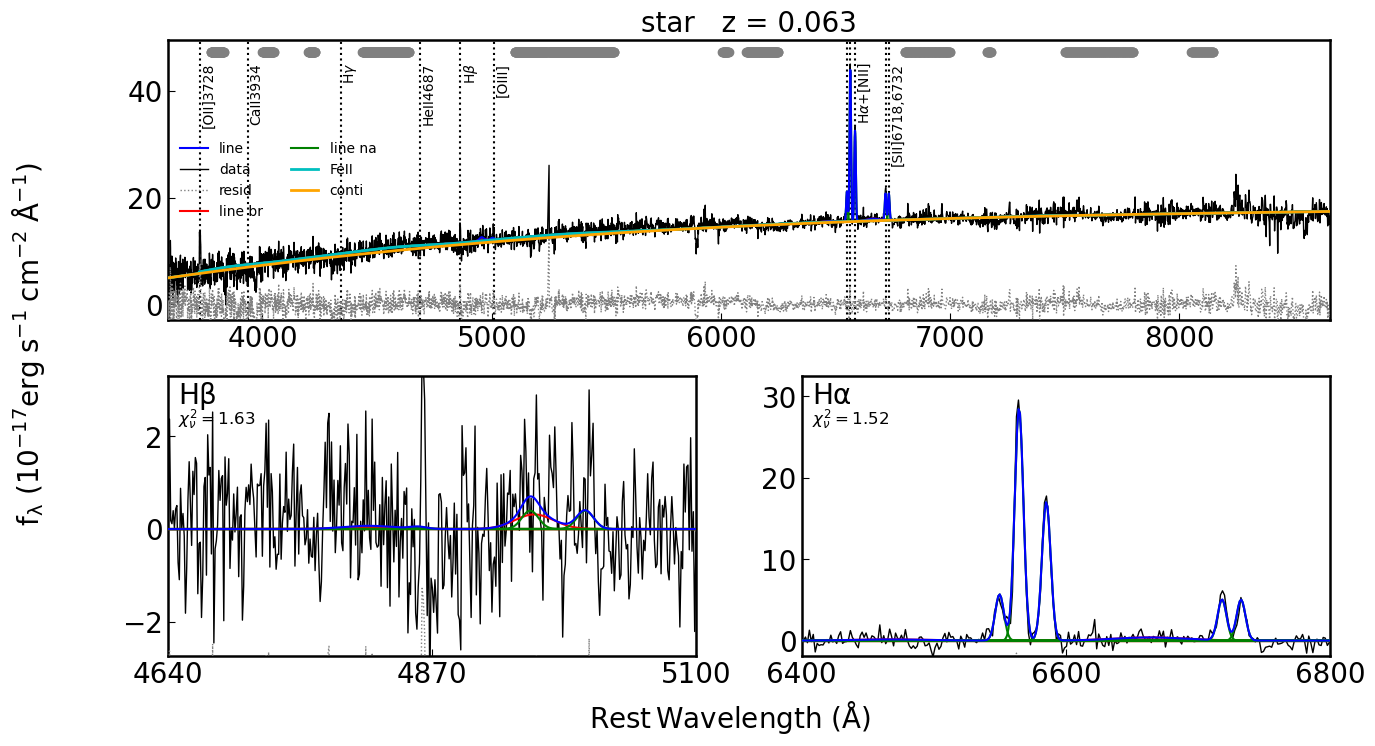

In [10]:
# Prepare data
q_mle = QSOFit(lam, flux, err, z, path=path_ex)

# Double check the installation path with the PCA / Fe template files
# print('install path:', q_mle.install_path)

# Change it if you installed them somewhere else
#q_mle.install_path = '...'

start = timeit.default_timer()
# Do the fitting

q_mle.Fit(name= "AGN",  # customize the name of given targets. Default: plate-mjd-fiber
          # prepocessing parameters
          nsmooth=1,  # do n-pixel smoothing to the raw input flux and err spectra
          and_mask=False,  # delete the and masked pixels
          or_mask=False,  # delete the or masked pixels
          reject_badpix=True,  # reject 10 most possible outliers by the test of pointDistGESD
          deredden=True,  # correct the Galactic extinction
          wave_range=None,  # trim input wavelength
          wave_mask=None,  # 2-D array, mask the given range(s)

          # host decomposition parameters
          decompose_host=False,  # If True, the host galaxy-QSO decomposition will be applied
          host_prior=True, # If True, the code will adopt prior-informed method to assist decomposition. Currently, only 'CZBIN1' and 'DZBIN1' model for QSO PCA are available. And the model for galaxy must be PCA too.
          host_prior_scale=0.2, # scale of prior panelty. Usually, 0.2 works fine for SDSS spectra. Adjust it smaller if you find the prior affect the fitting results too much.

          host_line_mask=True, # If True, the line region of galaxy will be masked when subtracted from original spectra.
          decomp_na_mask=True, # If True, the narrow line region will be masked when perform decomposition
          qso_type='CZBIN1', # PCA template name for quasar
          npca_qso=10, # numebr of quasar templates
          host_type='PCA', # template name for galaxy
          npca_gal=5, # number of galaxy templates
          
          # continuum model fit parameters
          Fe_uv_op=True,  # If True, fit continuum with UV and optical FeII template
          poly=True,  # If True, fit continuum with the polynomial component to account for the dust reddening
          BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
          initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
          rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
          n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.

          # emission line fit parameters
          linefit=True,  # If True, the emission line will be fitted
          rej_abs_line=False,
          # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines

          # fitting method selection
          MC=False,
          # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
          MCMC=False,
          # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
          nsamp=200,
          # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

          # advanced fitting parameters
          param_file_name='qsopar.fits',  # Name of the qso fitting parameter FITS file.
          nburn=20,  # The number of burn-in samples to run MCMC chain
          nthin=10,  # To set the MCMC chain returns every n samples
          epsilon_jitter=0.,
          # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

          # customize the results
          save_result=False,  # If True, all the fitting results will be saved to a fits file
          save_fits_name=None,  # The output name of the result fits
          save_fits_path=path_out,  # The output path of the result fits
          plot_fig=True,  # If True, the fitting results will be plotted
          save_fig=False,  # If True, the figure will be saved
          plot_corner=True,  # Whether or not to plot the corner plot results if MCMC=True

          # debugging mode
          verbose=True,  # turn on (True) or off (False) debugging output

          # sublevel parameters for figure plot and emcee
          kwargs_plot={
              'save_fig_path': '.',  # The output path of the figure
              'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
          },
          kwargs_conti_emcee={},
          kwargs_line_emcee={})

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

In [11]:
q_mc = QSOFit(lam, flux, err, z, path=path_ex)

start = timeit.default_timer()
# Do the fitting

q_mc.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
         wave_mask=None, decompose_host=True, host_prior=True, decomp_na_mask=True, npca_gal=5, npca_qso=10, qso_type='CZBIN1',\
         Fe_uv_op=True, poly=True, rej_abs_conti=False, rej_abs_line=True, MC=True, nsamp=200, linefit=True, \
         save_result=True, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None, verbose=True)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

Got negative host galaxy / QSO flux over 10% of coverage, decomposition is not applied!
Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Balmer_Tau        0.5      0.1        2     None    False     None     None
Balmer_Te     1.5e+04    1e+04    5e+04     None    False     None     None
Blamer_norm         0        0    1e+10     None    False     None     None
Fe_op_FWHM       3000     1200  1.8e+04     None     True     None     None
Fe_op_norm          0        0    1e+10     None     True     None     None
Fe_op_shift         0    -0.01     0.01     None     True     None     None
Fe_uv_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_uv_norm          0        0    1e+10     None    False     None     None
Fe_uv_shift         0    -0.01     0.01     None    False     None     None
PL_norm             1        0    1e+10     None     True     None     None
PL_slope         -1.5       -5        3     None     True     None     Non

100%|██████████| 400/400 [00:39<00:00, 10.06it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [38.58237305 48.75903345 36.40657976 39.28997276 43.71586333 38.50909125
 40.57523081 40.45639483]


100%|██████████| 400/400 [00:09<00:00, 41.56it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 15 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [45.32913572 47.50614399 43.13314003 46.26393476 47.68077181 45.68658006
 45.45778171 47.25559677 42.8522627  46.19141934 42.18803607 44.44308114
 45.0355934  44.72550017 44.41046754]


100%|██████████| 400/400 [00:10<00:00, 36.62it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 11 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [41.48961042 47.02110129 48.95334395 41.64161473 46.09798616 47.31186824
 35.00134211 42.70026085 33.65655896 35.75026494 36.37575939]


Fitting finished in 200.1s


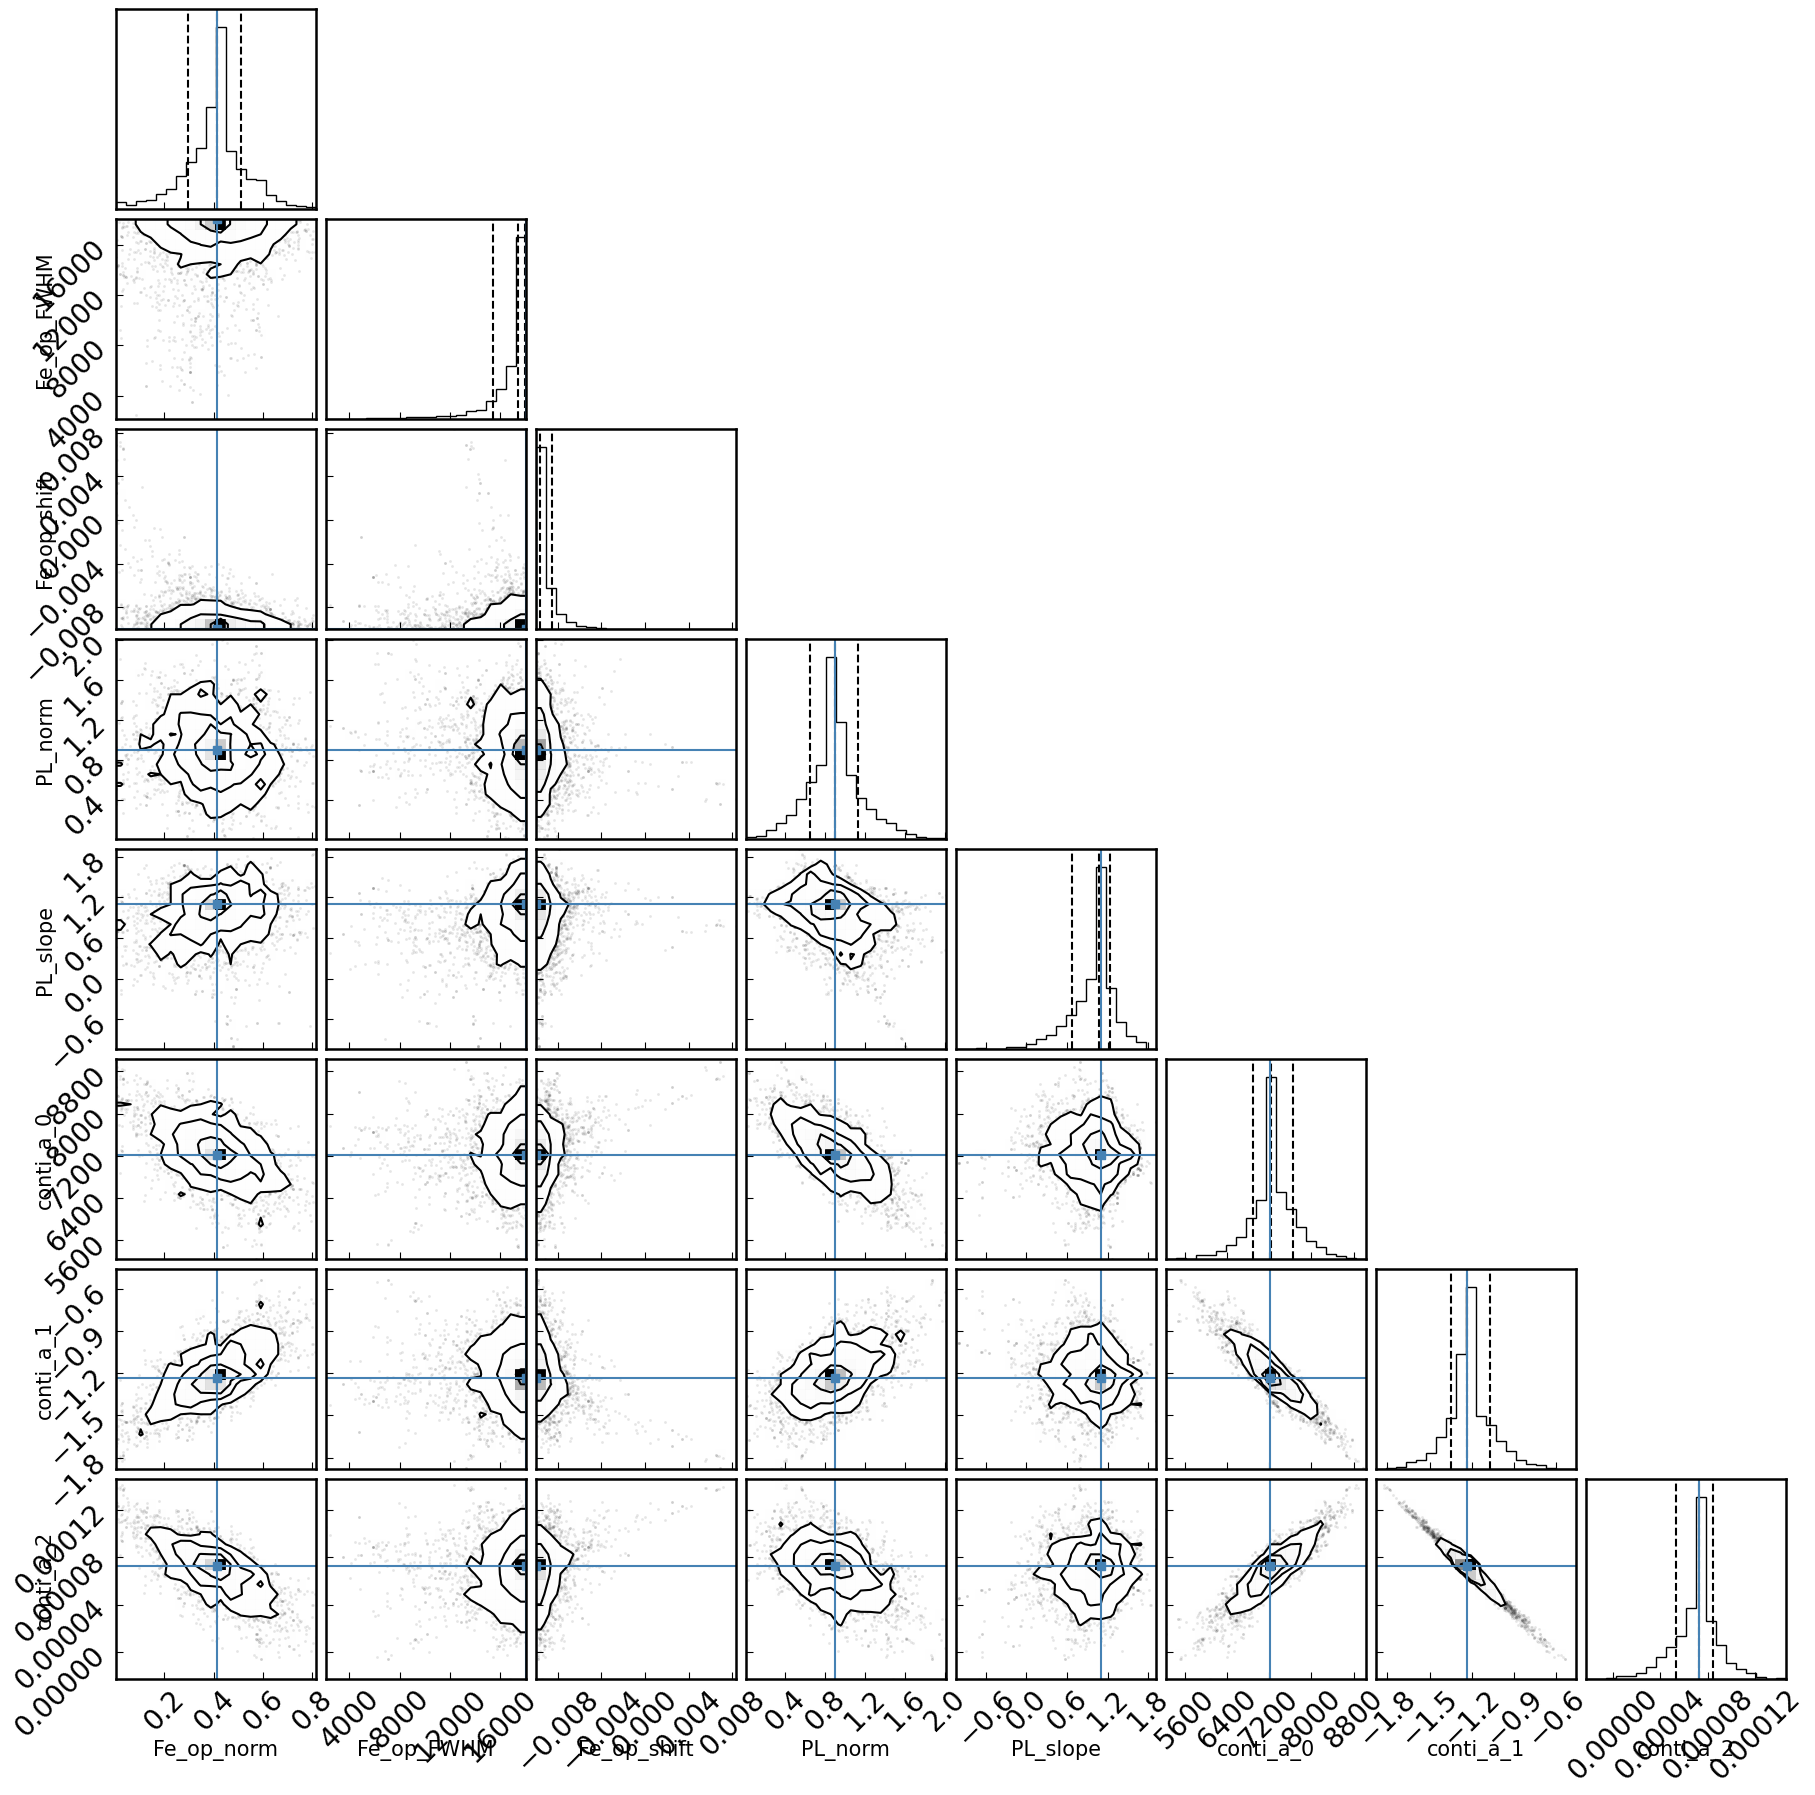

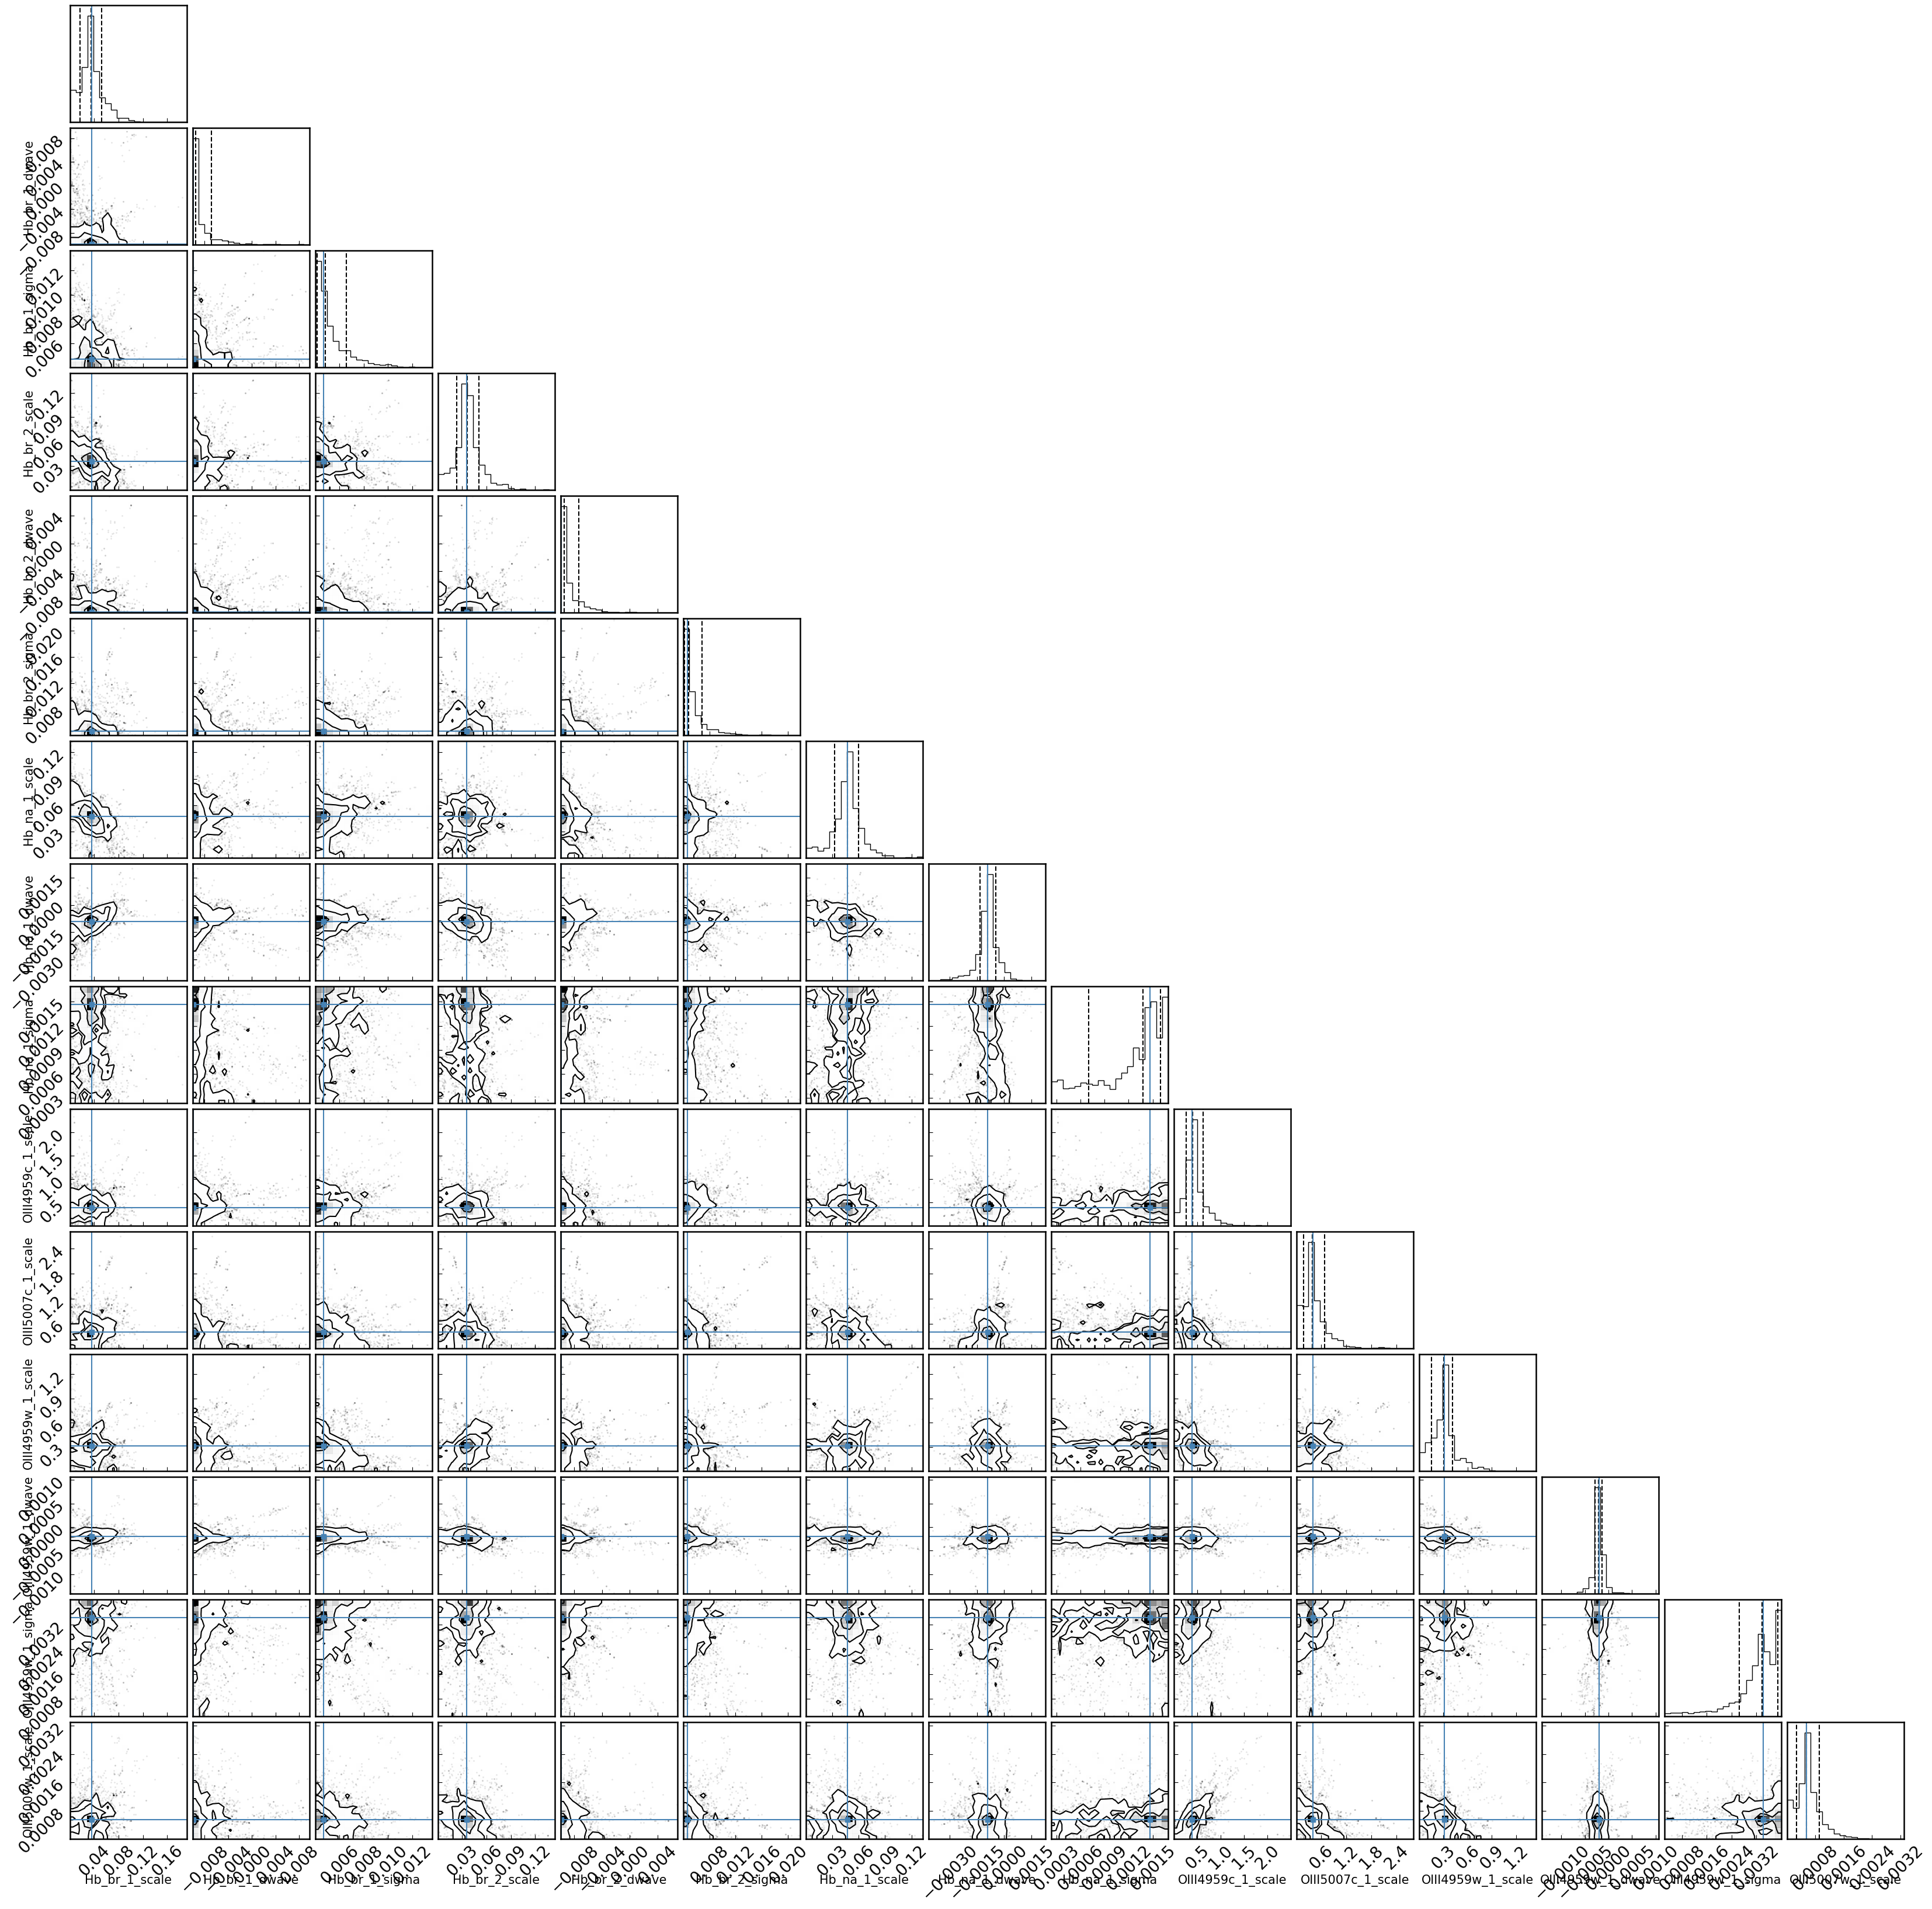

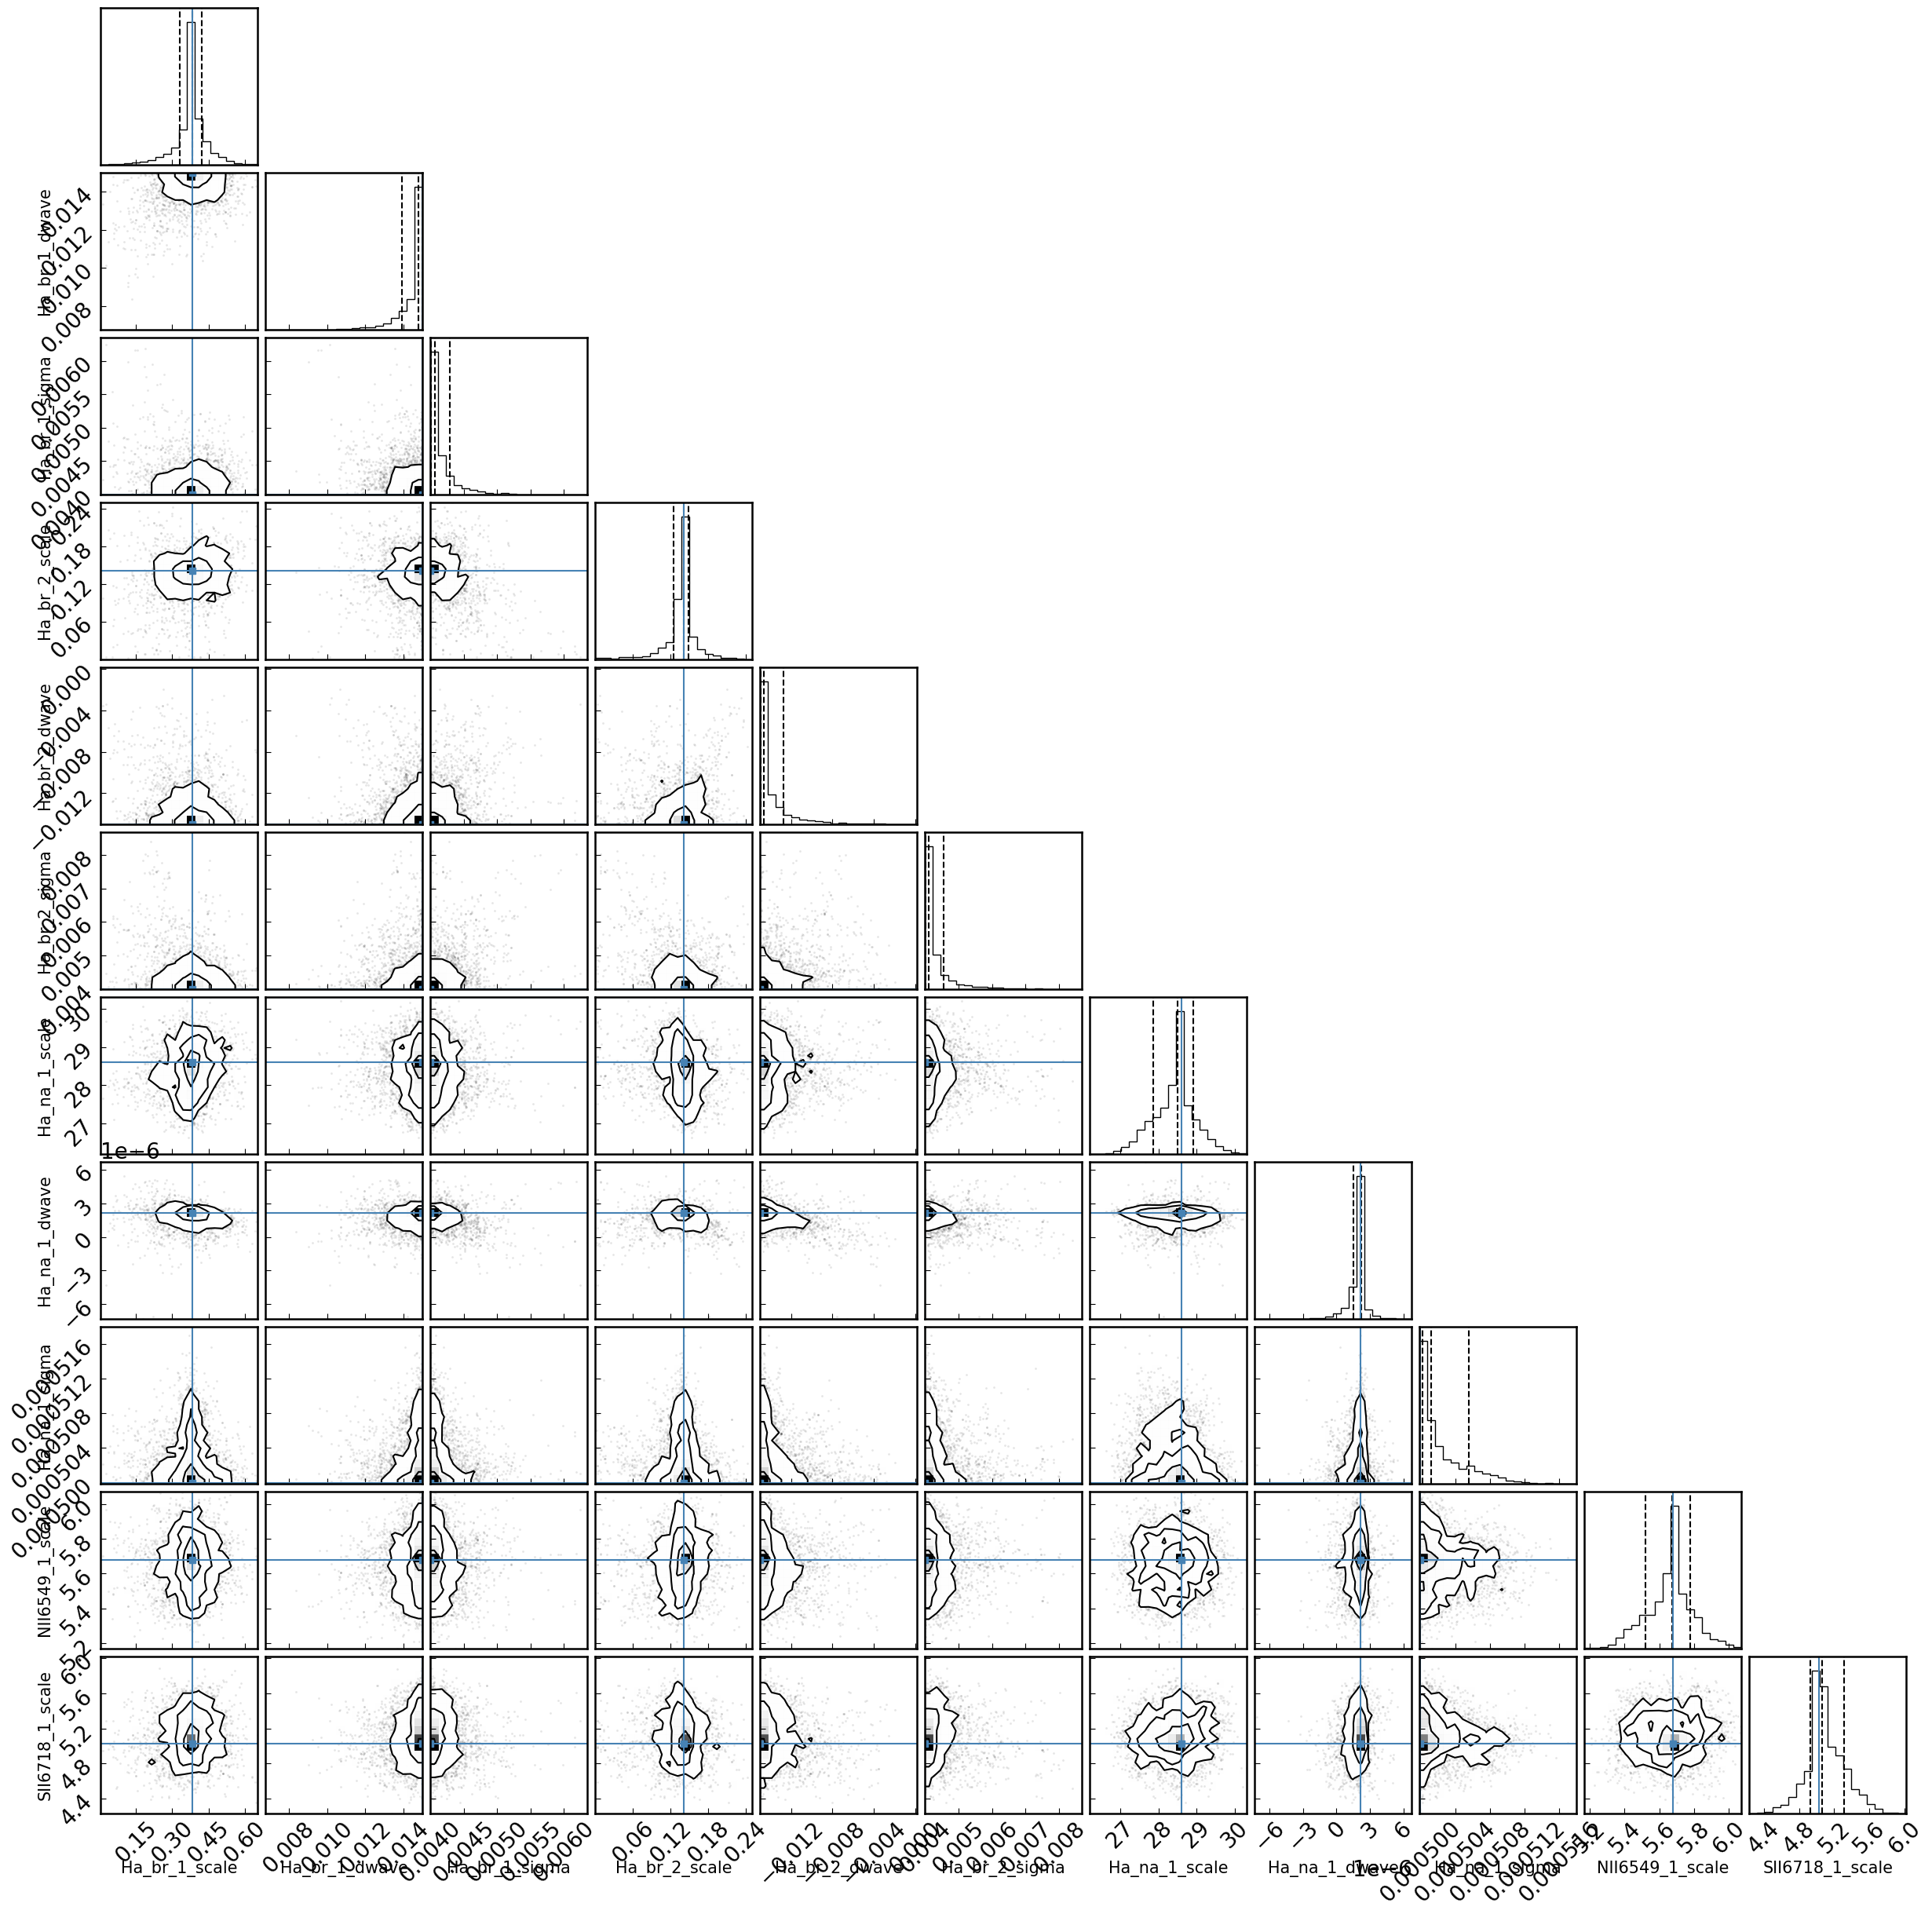

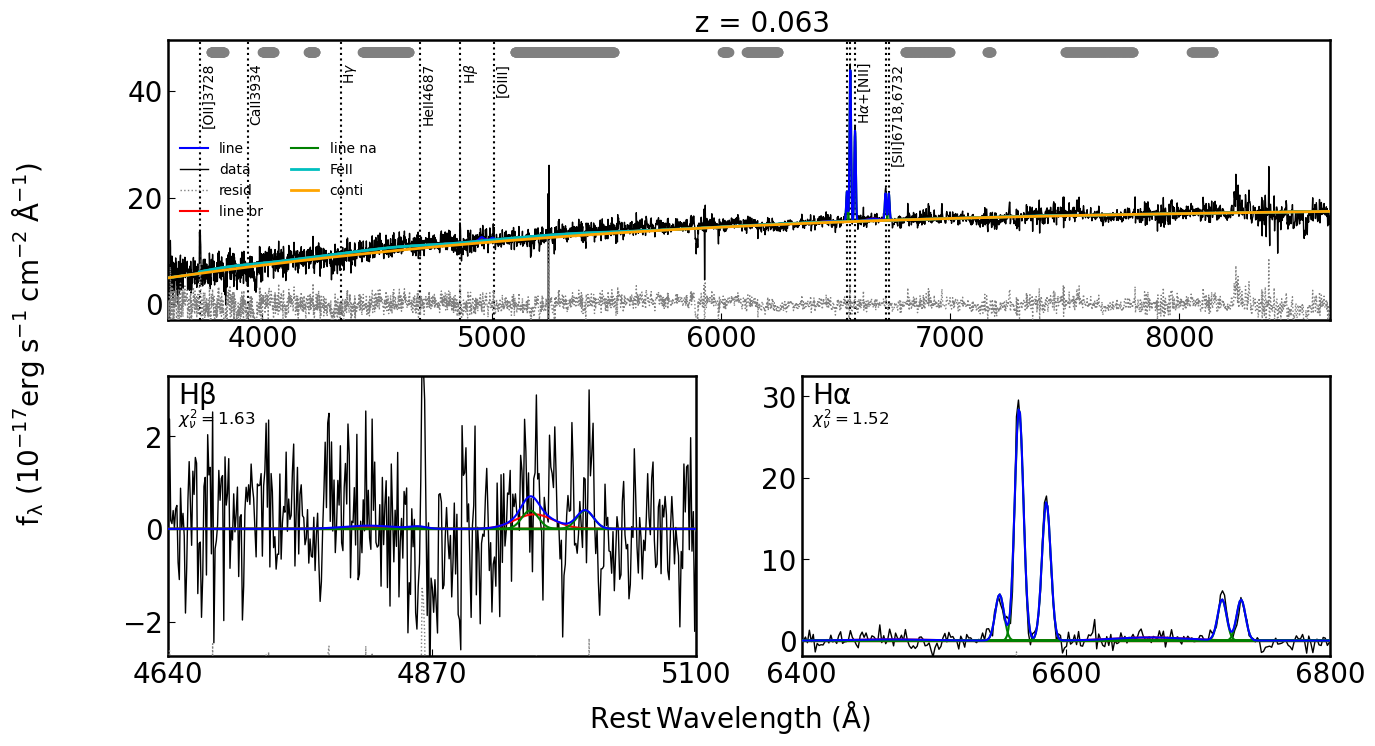

In [12]:
q_mcmc = QSOFit(lam, flux, err, z, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q_mcmc.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
           wave_mask=None, decompose_host=True, host_prior=True, decomp_na_mask=True, npca_gal=5, npca_qso=10, qso_type='CZBIN1',
           Fe_uv_op=True, poly=True, rej_abs_conti=False, \
           MCMC=True, epsilon_jitter=0, nburn=10, nsamp=400, nthin=10, linefit=True, save_result=True, \
           plot_fig=True, save_fig=False, plot_corner=True, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None,
           verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

In [13]:
# Continuum fitting results
print(q_mcmc.conti_result_name)
print('')
print(q_mcmc.conti_result)

['ra' 'dec' 'plateid' 'MJD' 'fiberid' 'redshift' 'SN_ratio_conti'
 'Fe_uv_norm' 'Fe_uv_norm_err' 'Fe_uv_FWHM' 'Fe_uv_FWHM_err' 'Fe_uv_shift'
 'Fe_uv_shift_err' 'Fe_op_norm' 'Fe_op_norm_err' 'Fe_op_FWHM'
 'Fe_op_FWHM_err' 'Fe_op_shift' 'Fe_op_shift_err' 'PL_norm' 'PL_norm_err'
 'PL_slope' 'PL_slope_err' 'Blamer_norm' 'Blamer_norm_err' 'Balmer_Te'
 'Balmer_Te_err' 'Balmer_Tau' 'Balmer_Tau_err' 'conti_a_0' 'conti_a_0_err'
 'conti_a_1' 'conti_a_1_err' 'conti_a_2' 'conti_a_2_err' 'L1350'
 'L1350_err' 'L1450' 'L1450_err' 'L3000' 'L3000_err' 'L4200' 'L4200_err'
 'L5100' 'L5100_err' 'Fe_flux_4435_4685' 'Fe_flux_4435_4685_err']

['-999' '-999' '0' '0' '0' '0.06296776' '13.24684140696848' '0.0' '0.0'
 '3000.0' '0.0' '0.0' '0.0' '0.41441183817880756' '0.10674739193045749'
 '17999.999993523135' '1289.2904227442941' '-0.009999999773706794'
 '0.000736358937492779' '0.9058886973889457' '0.24104731561819737'
 '1.107470858927046' '0.2764822986924108' '0.0' '0.0' '15000.0' '0.0'
 '0.5' '0.0' '7216.17061

In [38]:
# Gaussian fitting results
print(q_mcmc.gauss_result_name)
print('')
print(q_mcmc.gauss_result)

['Hb_br_1_scale' 'Hb_br_1_scale_err' 'Hb_br_1_centerwave'
 'Hb_br_1_centerwave_err' 'Hb_br_1_sigma' 'Hb_br_1_sigma_err'
 'Hb_br_2_scale' 'Hb_br_2_scale_err' 'Hb_br_2_centerwave'
 'Hb_br_2_centerwave_err' 'Hb_br_2_sigma' 'Hb_br_2_sigma_err'
 'Hb_na_1_scale' 'Hb_na_1_scale_err' 'Hb_na_1_centerwave'
 'Hb_na_1_centerwave_err' 'Hb_na_1_sigma' 'Hb_na_1_sigma_err'
 'OIII4959c_1_scale' 'OIII4959c_1_scale_err' 'OIII4959c_1_centerwave'
 'OIII4959c_1_centerwave_err' 'OIII4959c_1_sigma' 'OIII4959c_1_sigma_err'
 'OIII5007c_1_scale' 'OIII5007c_1_scale_err' 'OIII5007c_1_centerwave'
 'OIII5007c_1_centerwave_err' 'OIII5007c_1_sigma' 'OIII5007c_1_sigma_err'
 'OIII4959w_1_scale' 'OIII4959w_1_scale_err' 'OIII4959w_1_centerwave'
 'OIII4959w_1_centerwave_err' 'OIII4959w_1_sigma' 'OIII4959w_1_sigma_err'
 'OIII5007w_1_scale' 'OIII5007w_1_scale_err' 'OIII5007w_1_centerwave'
 'OIII5007w_1_centerwave_err' 'OIII5007w_1_sigma' 'OIII5007w_1_sigma_err'
 'Ha_br_1_scale' 'Ha_br_1_scale_err' 'Ha_br_1_centerwave'
 'Ha_b

In [14]:
# Gaussian fitting results
print(q_mcmc.gauss_result_name[::2])
print('')
print(q_mcmc.gauss_result_all)
print(np.shape(q_mcmc.gauss_result_all))

['Hb_br_1_scale' 'Hb_br_1_centerwave' 'Hb_br_1_sigma' 'Hb_br_2_scale'
 'Hb_br_2_centerwave' 'Hb_br_2_sigma' 'Hb_na_1_scale' 'Hb_na_1_centerwave'
 'Hb_na_1_sigma' 'OIII4959c_1_scale' 'OIII4959c_1_centerwave'
 'OIII4959c_1_sigma' 'OIII5007c_1_scale' 'OIII5007c_1_centerwave'
 'OIII5007c_1_sigma' 'OIII4959w_1_scale' 'OIII4959w_1_centerwave'
 'OIII4959w_1_sigma' 'OIII5007w_1_scale' 'OIII5007w_1_centerwave'
 'OIII5007w_1_sigma' 'Ha_br_1_scale' 'Ha_br_1_centerwave' 'Ha_br_1_sigma'
 'Ha_br_2_scale' 'Ha_br_2_centerwave' 'Ha_br_2_sigma' 'Ha_na_1_scale'
 'Ha_na_1_centerwave' 'Ha_na_1_sigma' 'NII6549_1_scale'
 'NII6549_1_centerwave' 'NII6549_1_sigma' 'NII6585_1_scale'
 'NII6585_1_centerwave' 'NII6585_1_sigma' 'SII6718_1_scale'
 'SII6718_1_centerwave' 'SII6718_1_sigma' 'SII6732_1_scale'
 'SII6732_1_centerwave' 'SII6732_1_sigma']

[[3.35282864e-02 8.47961755e+00 4.74739649e-03 ... 5.02760167e+00
  8.81472896e+00 5.00000024e-04]
 [3.59265901e-02 8.47953937e+00 4.56795971e-03 ... 5.02760167e+00
  8.81

In [40]:
# line fitting results
print(q_mcmc.line_result_name)
print('')
print(q_mcmc.line_result)

['1_complex_name' '1_line_status' '1_line_min_chi2' '1_line_bic'
 '1_line_red_chi2' '1_niter' '1_ndof' '2_complex_name' '2_line_status'
 '2_line_min_chi2' '2_line_bic' '2_line_red_chi2' '2_niter' '2_ndof'
 'Hb_br_1_scale' 'Hb_br_1_scale_err' 'Hb_br_1_centerwave'
 'Hb_br_1_centerwave_err' 'Hb_br_1_sigma' 'Hb_br_1_sigma_err'
 'Hb_br_2_scale' 'Hb_br_2_scale_err' 'Hb_br_2_centerwave'
 'Hb_br_2_centerwave_err' 'Hb_br_2_sigma' 'Hb_br_2_sigma_err'
 'Hb_na_1_scale' 'Hb_na_1_scale_err' 'Hb_na_1_centerwave'
 'Hb_na_1_centerwave_err' 'Hb_na_1_sigma' 'Hb_na_1_sigma_err'
 'OIII4959c_1_scale' 'OIII4959c_1_scale_err' 'OIII4959c_1_centerwave'
 'OIII4959c_1_centerwave_err' 'OIII4959c_1_sigma' 'OIII4959c_1_sigma_err'
 'OIII5007c_1_scale' 'OIII5007c_1_scale_err' 'OIII5007c_1_centerwave'
 'OIII5007c_1_centerwave_err' 'OIII5007c_1_sigma' 'OIII5007c_1_sigma_err'
 'OIII4959w_1_scale' 'OIII4959w_1_scale_err' 'OIII4959w_1_centerwave'
 'OIII4959w_1_centerwave_err' 'OIII4959w_1_sigma' 'OIII4959w_1_sigma_err'
 'O

Fe flux within a specific range: 
Fe_flux_4400_4900: 258.99386843172675


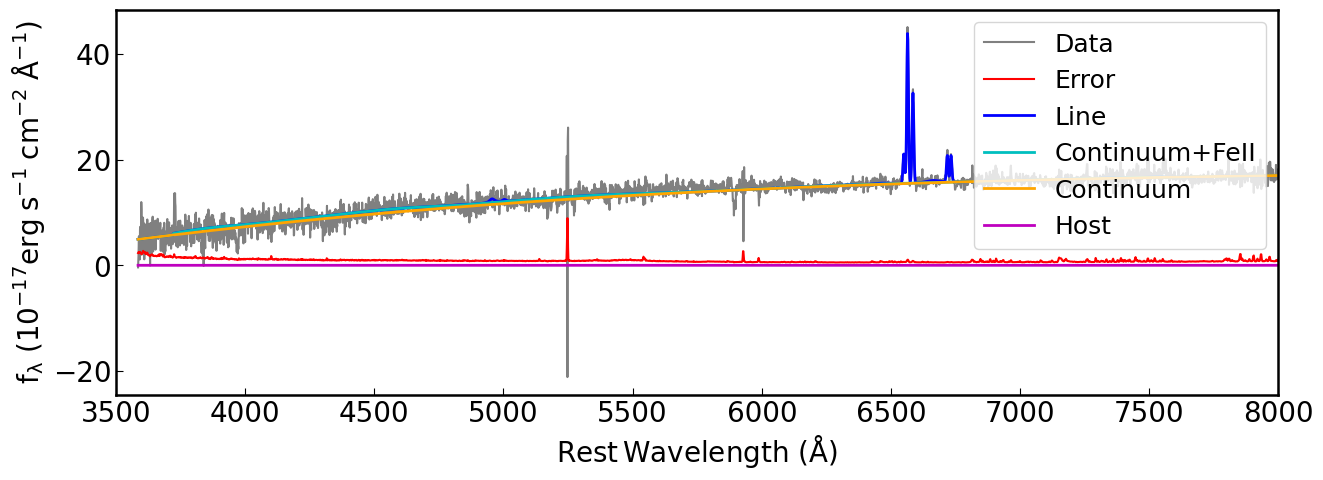

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the quasar rest frame spectrum after removed the host galaxy component
ax.plot(q_mcmc.wave, q_mcmc.flux, 'grey', label='Data')
ax.plot(q_mcmc.wave, q_mcmc.err, 'r', label='Error')

# Skip the error results before plotting
if q_mcmc.MCMC == True:
    gauss_result = q_mcmc.gauss_result[::2]
else:
    gauss_result = q_mcmc.gauss_result

# To plot the whole model, we use Manygauss to show the line fitting results saved in gauss_result
ax.plot(q_mcmc.wave, q_mcmc.Manygauss(np.log(q_mcmc.wave), gauss_result) + q_mcmc.f_conti_model, 'b', label='Line',
        lw=2)
ax.plot(q_mcmc.wave, q_mcmc.f_conti_model, 'c', lw=2, label='Continuum+FeII')
ax.plot(q_mcmc.wave, q_mcmc.PL_poly_BC, 'orange', lw=2, label='Continuum')
ax.plot(q_mcmc.wave, q_mcmc.host, 'm', lw=2, label='Host')
plt.legend()

ax.set_xlim(3500, 8000)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

#print('optical Fe flux (10^(-17) erg/s/cm^2): ' + q_mcmc.conti_result[q_mcmc.conti_result_name=='Fe_flux_4435_4685'][0])

Fe_flux_result, Fe_flux_type, Fe_flux_name = q_mcmc.Get_Fe_flux(np.array([4400, 4900]))
print('Fe flux within a specific range: \n' + Fe_flux_name[0] + ': ' + str(Fe_flux_result[0]))


Broad Hb:
FWHM (km/s) 3268.1
Sigma (km/s) 1369.2
EW (A) 0.4
Peak (A) 4814.9
Area (10^(-17) erg/s/cm^2) 4.0

Narrow [OIII]5007:
FWHM (km/s) 1037.0
Sigma (km/s) 433.3
EW (A) 0.6
Peak (A) 5003.0
Area (10^(-17) erg/s/cm^2) 7.2


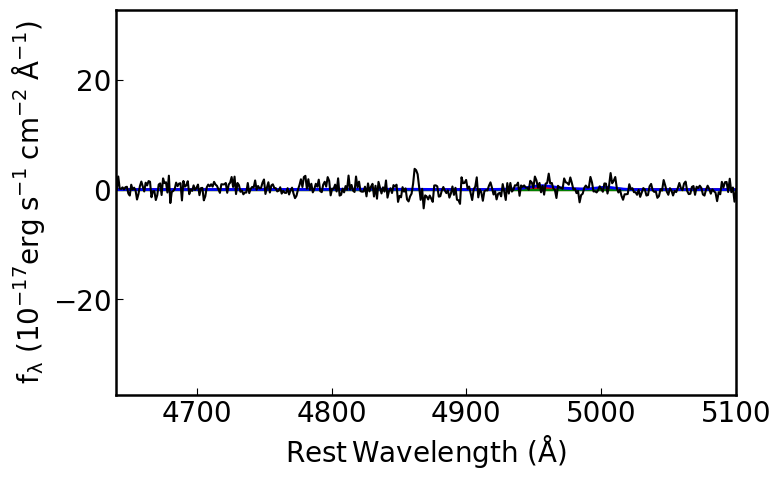

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

if q_mcmc.MCMC:
    gauss_result = q_mcmc.gauss_result[::2]
else:
    gauss_result = q_mcmc.gauss_result

# Plot individual line components
for p in range(int(len(gauss_result) / 3)):
    if q_mcmc.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q_mcmc.wave, q_mcmc.Onegauss(np.log(q_mcmc.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

# Plot total line model
ax.plot(q_mcmc.wave, q_mcmc.Manygauss(np.log(q_mcmc.wave), gauss_result), 'b', lw=2)
ax.plot(q_mcmc.wave, q_mcmc.line_flux, 'k')
ax.set_xlim(4640, 5100)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

"""
Line properties
"""

# The line_prop function is used to calculate the broad line properties
# (defined, by default, as ln sigma > 0.00169 (1200 km/s) )

# OLD WAY: If you want to calculate the paramters of broad Hb
# then find all the broad Hb component, i.e., Hb_br_[1,2,3]_[scale,centerwave,sigma]
# for here q.line_result_name[12:15], q.line_result[12:15] is the broad Hb
# If MCMC=False, this would be:
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[12:15], 'broad')

# NEW WAY: using line_prop_from_name convenience function
fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name('Hb_br', 'broad')

print("Broad Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")

# OLD WAY: If you want to calculate the  the narrow [OIII]5007
# If MCMC=False, this would be:
# the coresponding parameters are  q.line_result_name[21:24], q.line_result[21:24]
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[21:24], 'narrow')

fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name('OIII5007c', 'narrow')

print("Narrow [OIII]5007:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))

In [21]:
z = 0.063
#dz = 0.000073
#H = 72E5/(3.086E24)
#dH = 8/(3.086E24)
F = 12.12E-17
dF = 0.823E-17
lam = 5.100609635025867647E3
V = 3268.1E5
dV = 180.9380537018535E5
c = 3E10
A = 1.55
dA = 0.02

B = 0.55
dB = 0.02
light_day = 2.59E15 #cm

D = (284.5E6)*3E18
dD = 0

#D*((dz/z)-(dH/H))
print("Distance of the galaxy", D ,"+/-", dD)

L = F*4*np.pi*((D)**2)
dL = L*((2*(dD/D))+(dF/F))
print("Luminisity", L,"+/-", dL)
print(lam*L)

R = (10**(A+(B*np.log10(lam*L/10E44))))*light_day
dR = R*(dA+dB*((dL/L**2)))

print("BLR distance", R, "+/-", dR)

l = 4861E-8

print("BLR velocity", V, "+/-", dV)

G = 6.67E-8
M = 1.12*(V**2)*(R/G)
dM = M*(2*(dV/V)+(dR/R))
MS = 2E33
print("BH mass", M/MS, "+/-", dM/MS)

Distance of the galaxy 8.535e+26 +/- 0
Luminisity 1.1094801453828797e+39 +/- 7.533846201733581e+37
5.659025119409816e+42
BLR distance 5337128459968002.0 +/- 106742569199360.05
BLR velocity 326810000.0 +/- 18093805.37018535
BH mass 4785865.872607787 +/- 625655.3586796431
